# Get uncertainty of data far beyond training data 

This experiment only uses the original kind of data, but tries to predict far beyond this known data.
So, we are going to train with original data and get prediction far away, in order to get how uncertatinty is predicted by model far away from training data.

Original experiment[1] only provides data at [0,1] and previous experiments show it seems to work in that interval, showing how uncertainty follows the variance of the data. But, what happen when we try to predict far away from known data. An intuitive idea is that as you walk away from known data the uncertainty should increase.

However, we don't know what could be the output: uncertainty reaches a maximum and remains stable? uncertainty increase exponentially? linearly? should it be infinity at some point?

This technique doesn't set explicitly for a behaviour in this context, so we don't know what could be its behaviour and if it is correct from some point of view.

Hipothesis: variance should increase as long as it is away from trainign data, since knowledge uncertainty increases being far from known data.

You can see the initial experiment reproduction at "initial validation" in this repository.

[1] Original base experiment at: https://github.com/sthorn/deep-learning-explorations/blob/master/predicting-uncertainty.ipynb



### Imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as m
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import copy

%matplotlib inline

### Generate some random data

We generate the same kind of random data than in original experiment. This data has an higher variance at some point and almost no variance in others, in order to show how this method learns this properties. Data is only generated for [0,1] interval. 

In [3]:
# Generate some linearly related data
n_samples = 10000
np.random.seed(4567)

In [4]:
x = np.random.random(n_samples)                      
eps = np.random.normal(scale=1.0, size=n_samples) * 0.4*np.sin(x*4*np.pi)
y = 2*x + 1 + eps

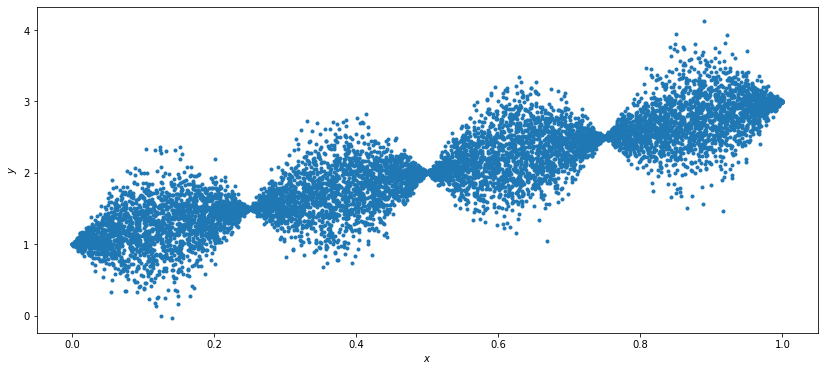

In [5]:
# Plot the data
plt.figure(figsize=(14,6))
plt.plot(x, y, '.')
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

In [6]:
# Add in column of dummy zeros to represent sigma 
sigma = np.zeros(n_samples)
y = np.stack([y, sigma], axis=1)

In [7]:
# Reshape x for PyTorch
x = x.reshape(n_samples, 1)

# ¡¡WARNING!!
This is a experiment, we don't know the correct output. So we can't validate the output, and, indeed, we can't use validation data to validate the output. So we don't make the split between training and validation.

In [8]:
# Split into training and validation sets
#n_validation = 500
#x_val, x = x[:n_validation], x[n_validation:]
#y_val, y = y[:n_validation], y[n_validation:]

In [9]:
# Convert x and y to PyTorch Variables on the GPU
dtype = torch.FloatTensor
x = Variable(torch.from_numpy(x).type(dtype))
y = Variable(torch.from_numpy(y).type(dtype), requires_grad=False)

In [10]:
# Check shape ok for PyTorch - x should be (n x 1), y (n x 2)
x.shape, y.shape

(torch.Size([10000, 1]), torch.Size([10000, 2]))

### Create a simple network 

In [11]:
# Create a simple two-layer network with one input (x) and two outputs (y, sigma)
n_inputs = 1
n_outputs = 2
n_hidden = 1000
model = torch.nn.Sequential(torch.nn.Linear(n_inputs, n_hidden),
                            torch.nn.ReLU(),
                            torch.nn.Linear(n_hidden, n_outputs)
                           )

In [12]:
# Adam optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Custom loss function
This is where the magic happens.

In [13]:
def custom_loss(input, target):
    
    # Estimate target value for sigma with abs(y_pred - y)
    #
    #    actual y     is target[:,0]
    # predicted y     is input[:,0]
    #    actual sigma is target[:,1]
    # predicted sigma is input[:,1]
    
    # Use 'requires_grad == False' to prevent PyTorch from trying to differentiate 'target'
    target[:,1] = Variable((input[:,0].data - target[:,0].data).abs(), 
                           requires_grad=False)  
    # Return MSE loss 
    return F.mse_loss(input, target)

### Training loop 
We train this simple model with batch size equal to the whole dataset.

In [14]:
n_epochs = 10000
for i in range(n_epochs):
    
    # Calculate predicted y from x
    y_pred = model(x)
    
    # Calculate loss
    loss = custom_loss(y_pred, y)
    
    if i%500 == 0: print(f'epoch: {i:4}, loss: {loss.data:.3}',)

    # Backprop, first zeroing gradients
    optimizer.zero_grad()
    loss.backward()

    # Update parameters
    optimizer.step()

epoch:    0, loss: 5.51
epoch:  500, loss: 0.0618
epoch: 1000, loss: 0.0613
epoch: 1500, loss: 0.061
epoch: 2000, loss: 0.0608
epoch: 2500, loss: 0.0605
epoch: 3000, loss: 0.0603
epoch: 3500, loss: 0.0601
epoch: 4000, loss: 0.0598
epoch: 4500, loss: 0.0596
epoch: 5000, loss: 0.0593
epoch: 5500, loss: 0.0591
epoch: 6000, loss: 0.0588
epoch: 6500, loss: 0.0585
epoch: 7000, loss: 0.0582
epoch: 7500, loss: 0.0579
epoch: 8000, loss: 0.0576
epoch: 8500, loss: 0.0573
epoch: 9000, loss: 0.057
epoch: 9500, loss: 0.0568


### Get predictions for data beyond training

We are going to predict in the following ranges: 

The first one (x_far_away) is an interval from 1 to 1199 and (x_far_away_negative) -1 to -1199, with steps of 10. This way we go far beyond known data and we can see if uncertainty increases along X axis.

The second one is a interval for fine grain far beyond known data (x_far_away_fg), from 1199 to 1200 and steps of 0.01. This way we can see if sine shape is kept far beyond known data. 

The third one (x_trained_interval) is the original range [0,1], for validating the method maintains the behaviour of base experiment.

Finally, the fourth one are the adjacent zones to training data [-1,0] and [1,2], in order to verify the sine shape is predicted by the model.


In [15]:


#X for predicting data beyond training interval using positive an negative axis zones
x_far_away=np.arange(1.0,1199.0,10)
x_far_away_negative=np.arange(-1199.0,-1,10)
x_far_away_negative=x_far_away_negative.reshape(int(1200/10), 1)
x_far_away=x_far_away.reshape(int(1200/10), 1)
x_far_away_negative=x_far_away_negative.reshape(int(1200/10), 1)

#X for predicting data beyond training interval with fine grain
x_far_away_fg=np.arange(1199,1200.0,0.01)
x_far_away_fg=x_far_away_fg.reshape(100, 1)

#Predicting inside training interval too in order to validate it learns from data
x_trained_interval=np.arange(0.0,1.0,0.01)
x_trained_interval=x_trained_interval.reshape(100, 1)

#Predicting adjacent zones to trainig data in order to review if sine shape is predicted there
x_positive_adjacent_training=np.arange(1.0,2.0,0.01)
x_negative_adjacent_training=np.arange(-1.0,0.0,0.01)
x_positive_adjacent_training=x_positive_adjacent_training.reshape(100, 1)
x_negative_adjacent_training=x_negative_adjacent_training.reshape(100, 1)

x_to_predict=np.concatenate((x_far_away_negative,x_negative_adjacent_training, x_trained_interval,x_positive_adjacent_training,x_far_away,x_far_away_fg))



x_val_pytorch = Variable(torch.from_numpy(x_to_predict).type(dtype)) 
pred = model(x_val_pytorch)
y_pred = pred[:,0].cpu().data
sigma_pred = pred[:,1].cpu().data


### Plot results

Firstly, we plot the predictions and uncertainty for the entire range, with a zoom out view.

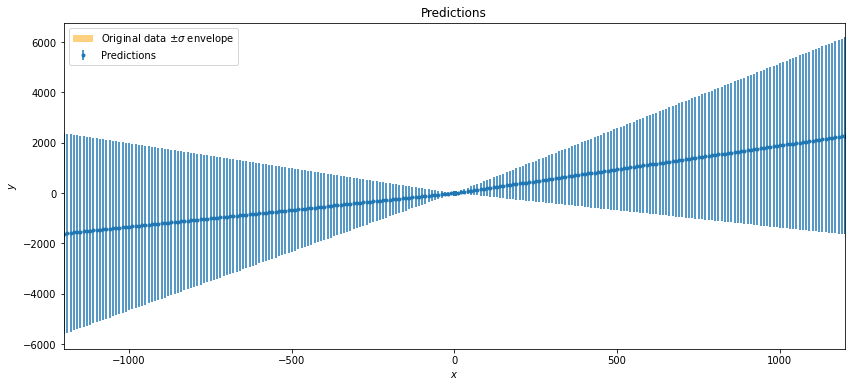

In [17]:
# Plot predictions and their errors
plt.figure(figsize=(14,6))
plt.errorbar(x_to_predict, y_pred, yerr=sigma_pred, fmt='.');
xs = np.linspace(0.0, 1.0, 50)
err = 0.4*np.sin(xs*4*np.pi)
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.xlim(-1200,1200);
plt.title('Predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Predictions'], loc='upper left', );

The result shows how uncertainty increase along x axis. It seems to be increased linearly. In principle, it makes some kind of sense.

If we make zoom in the first points:

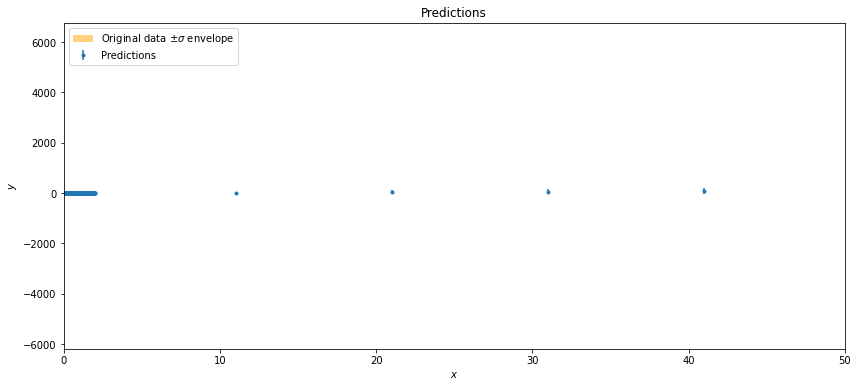

In [18]:
plt.figure(figsize=(14,6))
plt.errorbar(x_to_predict, y_pred, yerr=sigma_pred, fmt='.');
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.xlim(0,50);
plt.title('Predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Predictions'], loc='upper left', );

We can see how uncertainty is increased slowly too.


Making zoom in training interval:

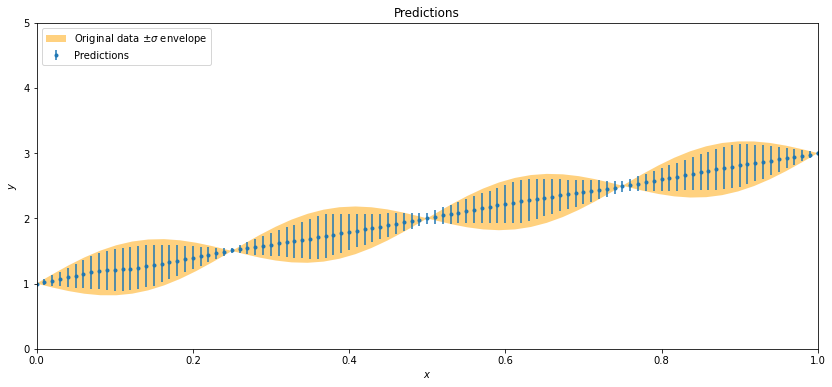

In [19]:
plt.figure(figsize=(14,6))
plt.errorbar(x_to_predict, y_pred, yerr=sigma_pred, fmt='.');
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.xlim(0,1);
plt.ylim(0,5);
plt.title('Predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Predictions'], loc='upper left', );

So the original sine form is learnt in training interval and uncertainty is still there, like the previous expriments.

At this point, we are going to zoom in fine grain prediction far beyond known data, [1199,1200] range, in order to review if sine shape is there in predicted data.

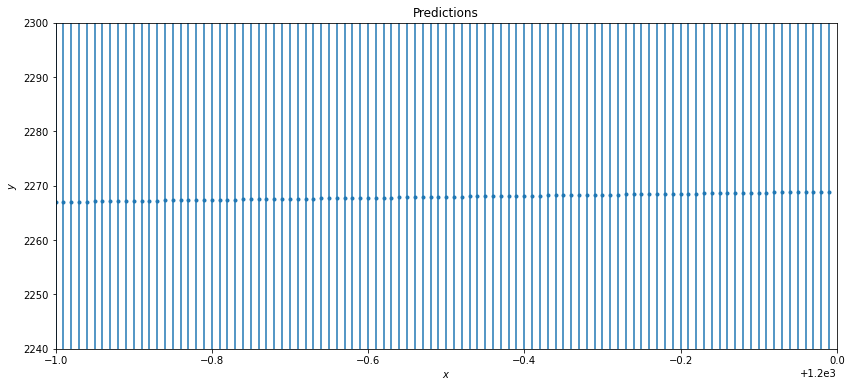

In [24]:
plt.figure(figsize=(14,6))
plt.errorbar(x_to_predict, y_pred, yerr=sigma_pred, fmt='.');
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.xlim(1199,1200);
plt.ylim(2240,2300)
plt.title('Predictions');

 The model only has learnt the linear component, but not the sine shape. Specificly the following component:

In [51]:
print (str(float(y_pred[220]))+"+"+str(float(y_pred[639])/float(x_to_predict[639]))+"X")

0.9966758489608765+1.890757130007335X


That is the "y = 2*x + 1 + eps" of the generation data section, as we could expect.

The incertainty increases linearly along the following slope, we don't know why:

In [52]:
float(sigma_pred[639])/float(x_to_predict[639])

-3.263305799358226

Now we are going to review the sine shape in adjacent zones to training data.

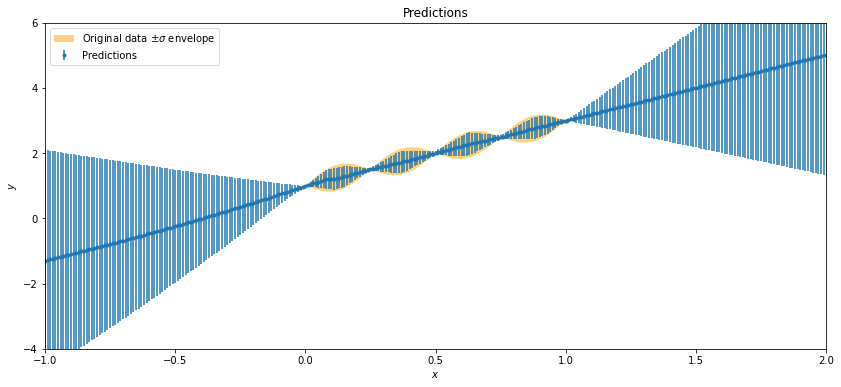

In [32]:
plt.figure(figsize=(14,6))
plt.errorbar(x_to_predict, y_pred, yerr=sigma_pred, fmt='.');
plt.fill_between(xs, 2*xs+1-err, 2*xs+1+err, facecolor='orange', alpha=0.5, edgecolor='none');
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');
plt.xlim(-1,2);
plt.ylim(-4,6)
plt.title('Predictions');
plt.legend([r'Original data $\pm \sigma$ envelope','Predictions'], loc='upper left', );

So sine shape is not predicted beyond trainig data. It could be interpreted as good, since there is no knowledge about this zone, so prediction is only the linear component with increasing uncertainty, or it could be interpreted as a fail, since the same behaviour than training data could be expected outside that range. 

# Conclusions

Initially, the result is the expected result for this data: the uncertainty is increased as long as the prediction is far away from known data.

However, **it increases linearly and this can't be explained**. Besides, the model **learns the sine shape** in training data, but not beyond that point, so **it can be overfitted** for that data.

So,the model behaviour is some kind of expected, but the **results are not conclusive** about its behaviour in any situation. 

